In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from torchtext.legacy.data import Field, TabularDataset, BucketIterator
import matplotlib.pyplot as plt
source_folder = "solo_classifier_dataset_text"
destination_folder = "solo_classifier_weights"

In [2]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu" 
print(dev)
device = torch.device(dev)
print(device)

cuda:0
cuda:0


In [31]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('labels', label_field), ('notes', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='val.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.notes),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.notes),
                            device=device, sort=False, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.notes),
                            device=device, sort=False, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=1)

In [32]:
for (labels, (notes, notes_len)), _ in (train_iter):
    print(notes)

tensor([[ 9,  3,  2,  3,  9, 15,  9, 25, 33, 25,  9, 22, 15, 22, 15,  9, 25],
        [15, 21, 25,  2,  2,  3, 10, 11, 11,  6,  2,  9,  9,  6,  3, 11, 15],
        [ 9,  9,  9, 14, 14, 14, 14, 11, 11, 11, 11,  3,  3, 11, 14,  9, 12],
        [11,  3,  2,  3, 11,  3, 11,  3, 11,  3,  2, 15, 19, 15,  9, 15,  1],
        [ 2,  5, 10,  3,  6,  5,  2,  4,  9,  9,  5,  2,  3,  4,  6,  4,  1],
        [14, 11,  3, 11, 14, 11, 15, 22,  8,  8,  3, 14, 15, 11,  3,  3,  1],
        [18,  4,  7,  5,  7,  5,  8,  7,  4, 14,  8,  7,  4, 18, 14, 28,  1],
        [19, 18,  9, 19,  4,  6,  9,  6, 19,  8,  4, 39, 28, 19,  9,  4,  1],
        [ 9, 11, 11,  2, 22, 14, 14,  3, 12, 12, 10,  8,  2,  8, 12,  1,  1],
        [11,  6,  9, 15, 21,  2, 21,  2, 21,  2, 21,  2, 21,  2, 20,  1,  1],
        [14, 11, 14, 10,  8,  7, 10,  8,  7,  8, 10, 17, 11,  7, 22,  1,  1],
        [24, 20, 24, 20, 24, 20, 24, 29, 17, 20, 29, 34, 31, 20,  1,  1,  1],
        [11,  3,  3, 11, 14,  9, 15,  9, 15,  9, 25, 22, 15, 25,

In [4]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [24]:
class LSTM(nn.Module):

    def __init__(self, dimension=64):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, notes, notes_len):
        notes_emb = self.embedding(notes)
        print(notes_emb.size())
        packed_input = pack_padded_sequence(notes_emb, notes_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), notes_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        print(out_reduced)
        notes_fea = self.drop(out_reduced)

        notes_fea = self.fc(notes_fea)
        notes_fea = torch.squeeze(notes_fea, 1)
        notes_out = torch.sigmoid(notes_fea)

        return notes_out

In [25]:
# Save and Load Functions https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [26]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 10,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        total = 0
        total_correct = 0
        for (labels, (notes, notes_len)), _ in (train_loader):           
            labels = labels.to(device)
            notes = notes.to(device)
            notes_len = notes_len.cpu()
            output = model(notes.long(), notes_len.long())

            loss = criterion(output, labels.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            labels_max = labels.detach().cpu()
            output_max = torch.round(output.detach().cpu())

            for i in range(len(labels_max)):
                total+=1
                if labels_max[i] ==  output_max[i]:
                    total_correct += 1
            accuracy = accuracy_score(labels_max, output_max)
            
            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                    for (labels, (notes, notes_len)), _ in (valid_loader):
                        labels = labels.to(device)
                        notes = notes.to(device)
                        notes_len = notes_len.cpu()
                        output = model(notes.long(), notes_len.long())
                        loss = criterion(output, labels.float())
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
        print("Epoch Accuracy: {}".format(total_correct/total))
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=25)

torch.Size([32, 17, 300])
tensor([[ 0.1255,  0.0787, -0.0400,  ...,  0.1716,  0.0928,  0.1703],
        [-0.2216,  0.0372, -0.4017,  ..., -0.0159, -0.0311, -0.0444],
        [ 0.4711, -0.0076, -0.3718,  ...,  0.2728,  0.1350, -0.0560],
        ...,
        [ 0.2454,  0.2265,  0.0227,  ...,  0.0458,  0.0240,  0.0867],
        [ 0.1277, -0.0213, -0.0790,  ...,  0.2071,  0.0085,  0.1709],
        [-0.0703, -0.0934,  0.0533,  ..., -0.0206,  0.3155,  0.4882]],
       device='cuda:0', grad_fn=<CatBackward>)
torch.Size([32, 21, 300])
tensor([[ 9.4941e-02,  3.5156e-01, -7.8263e-02,  ..., -2.4239e-02,
          5.1485e-01,  1.0141e-01],
        [-6.7893e-01,  4.7921e-01,  1.6090e-01,  ...,  2.3011e-01,
          2.0666e-01,  1.6373e-01],
        [-2.7775e-02,  3.1345e-01,  2.0196e-02,  ...,  2.0512e-02,
          1.6765e-01, -5.2183e-02],
        ...,
        [ 2.5389e-02,  3.4770e-01, -1.3834e-01,  ...,  8.8503e-04,
          9.8206e-02, -4.4355e-02],
        [-6.5888e-01,  4.8478e-01,  1.3146

tensor([[ 0.4983,  0.1080,  0.1778,  ...,  0.0307,  0.0762, -0.0496],
        [ 0.1851, -0.2686, -0.2729,  ..., -0.1690,  0.0505,  0.0748],
        [ 0.1249,  0.2529,  0.3032,  ..., -0.1966,  0.0530,  0.1758],
        ...,
        [-0.2852,  0.3820, -0.0272,  ..., -0.0343, -0.0634, -0.2702],
        [ 0.0116,  0.1307,  0.4254,  ...,  0.0999, -0.0786, -0.0284],
        [ 0.6224, -0.0008, -0.0158,  ...,  0.1365, -0.0863,  0.2641]],
       device='cuda:0')
Epoch [1/25], Step [17/850], Train Loss: 0.6997, Valid Loss: 0.7062
Model saved to ==> solo_classifier_weights/model.pt
Model saved to ==> solo_classifier_weights/metrics.pt
torch.Size([32, 46, 300])
tensor([[ 0.3503,  0.1260,  0.5654,  ...,  0.1143,  0.0569, -0.0620],
        [ 0.5404,  0.2281,  0.5952,  ...,  0.1319,  0.0362, -0.0132],
        [ 0.0327, -0.0087, -0.5985,  ..., -0.1051,  0.1678, -0.4295],
        ...,
        [ 0.1797, -0.2740,  0.0039,  ...,  0.0189,  0.1123, -0.1270],
        [ 0.0353,  0.5985, -0.3882,  ..., -0.2133

torch.Size([2, 277, 300])
tensor([[-6.8778e-02,  2.9548e-01, -3.1522e-02,  6.5306e-01, -2.0276e-01,
          2.1743e-01, -3.6749e-02, -8.8282e-02, -2.2570e-02, -5.7085e-02,
         -4.2753e-02,  3.6634e-01, -8.6205e-02, -3.0161e-01,  4.2781e-03,
         -4.2851e-02, -3.9771e-01,  1.0956e-01,  3.9185e-03, -1.1637e-01,
         -9.6018e-02, -2.5367e-02, -5.5187e-02, -2.3347e-01, -1.3737e-01,
         -2.3123e-01,  3.2648e-01, -2.2571e-01,  9.3490e-02,  2.4306e-02,
         -1.0238e-01,  1.4889e-01, -1.4123e-01,  2.1985e-01, -3.8845e-02,
         -3.3272e-01,  3.7421e-01, -2.4773e-01,  3.2979e-01, -8.4948e-01,
          3.8080e-02,  1.0398e-02, -4.1866e-02, -5.0470e-01,  8.8399e-02,
         -1.6930e-01, -5.2529e-03,  1.2075e-01,  2.0237e-01, -4.2296e-01,
         -1.5044e-02, -6.9165e-03, -6.3089e-01,  5.1475e-01, -4.4014e-02,
         -4.6215e-02, -3.7666e-01, -1.0150e-01, -1.2964e-01,  3.8514e-01,
          7.7729e-02, -1.0635e-01, -3.8615e-01,  5.2098e-02,  1.4736e-01,
          5.

tensor([[ 0.0611,  0.1102,  0.0391,  ..., -0.0011,  0.5833,  0.4867],
        [ 0.3103,  0.0188, -0.2923,  ...,  0.0720,  0.2258, -0.0699],
        [-0.7023,  0.4345,  0.8331,  ...,  0.0630,  0.2590, -0.0432],
        ...,
        [ 0.0275,  0.0281, -0.0581,  ...,  0.0124,  0.0271,  0.4692],
        [ 0.0548,  0.0271, -0.0931,  ...,  0.0038,  0.0455,  0.2576],
        [-0.1773,  0.0126,  0.7102,  ...,  0.2166,  0.4118, -0.3223]],
       device='cuda:0', grad_fn=<CatBackward>)
torch.Size([32, 43, 300])
tensor([[-0.5365,  0.4500,  0.8358,  ...,  0.0973,  0.4319, -0.0902],
        [-0.0612,  0.0166,  0.1901,  ...,  0.1047,  0.1088, -0.0311],
        [ 0.0421,  0.1875, -0.0757,  ..., -0.0240,  0.1161,  0.1400],
        ...,
        [-0.4538,  0.0468,  0.1495,  ...,  0.0511,  0.2742, -0.0309],
        [ 0.0522,  0.4015, -0.0887,  ...,  0.0196,  0.2184, -0.4086],
        [ 0.2315,  0.0143, -0.2088,  ...,  0.0909,  0.2952, -0.0742]],
       device='cuda:0', grad_fn=<CatBackward>)
torch.Size([

torch.Size([32, 73, 300])
tensor([[ 0.0566,  0.0415, -0.2557,  ...,  0.0544,  0.0703, -0.0993],
        [-0.2919,  0.3990,  0.6704,  ...,  0.0326,  0.4737, -0.0480],
        [-0.0208,  0.1477,  0.4599,  ...,  0.1619,  0.5571,  0.4122],
        ...,
        [-0.1848,  0.0083,  0.1354,  ...,  0.1183, -0.1183,  0.0833],
        [ 0.1275, -0.1191, -0.2485,  ..., -0.0453,  0.0054,  0.2243],
        [-0.0522, -0.1146, -0.1192,  ..., -0.0100, -0.0841,  0.3961]],
       device='cuda:0', grad_fn=<CatBackward>)
torch.Size([32, 78, 300])
tensor([[-5.0195e-04,  9.7518e-03, -3.5887e-01,  ...,  1.9638e-01,
          4.7980e-01, -1.6673e-02],
        [ 6.7958e-01,  4.1863e-02,  7.6415e-01,  ...,  2.5548e-02,
         -1.3213e-01,  1.0174e-01],
        [ 1.3507e-01,  7.6130e-01, -3.1674e-02,  ...,  8.1513e-01,
          6.3557e-01,  6.6801e-02],
        ...,
        [ 1.9292e-01, -3.6125e-01,  8.2121e-01,  ...,  1.3344e-01,
          3.7323e-01, -3.8712e-01],
        [-3.0714e-01, -1.3055e-02,  1.2340

torch.Size([32, 31, 300])
tensor([[ 0.4141,  0.0873, -0.4846,  ..., -0.0812, -0.8514, -0.1824],
        [-0.2008,  0.7437, -0.0128,  ...,  0.0096,  0.0339,  0.2225],
        [ 0.0517,  0.3284, -0.0434,  ..., -0.2082, -0.0895,  0.1115],
        ...,
        [ 0.2177,  0.0107, -0.0933,  ...,  0.0381, -0.3266,  0.1167],
        [ 0.0336, -0.6989,  0.8420,  ...,  0.0796,  0.0762,  0.0189],
        [ 0.3690,  0.0038,  0.1417,  ...,  0.1167,  0.2477, -0.2345]],
       device='cuda:0', grad_fn=<CatBackward>)
torch.Size([32, 33, 300])
tensor([[ 3.7812e-01, -4.2517e-04, -3.8026e-01,  ...,  2.9259e-02,
          5.9609e-02,  4.7584e-01],
        [ 8.7271e-03,  6.3885e-01,  2.1015e-01,  ..., -8.2016e-02,
          1.8131e-01, -1.9661e-01],
        [-3.4204e-01,  6.6755e-01,  5.3674e-02,  ...,  8.9427e-02,
          1.8919e-01, -7.4076e-02],
        ...,
        [ 2.2468e-01,  6.0960e-02,  8.5517e-02,  ...,  4.1784e-02,
          4.6728e-01, -4.8411e-02],
        [ 2.3639e-01,  1.8507e-01,  6.6449

tensor([[-0.1115,  0.5619,  0.1918, -0.5711,  0.2282,  0.3901, -0.5384, -0.4013,
         -0.1036,  0.2769, -0.1448, -0.4983,  0.0251, -0.1615,  0.2367,  0.1892,
          0.5400, -0.0519, -0.1864,  0.2551,  0.0608, -0.3317,  0.1046,  0.6249,
         -0.2335, -0.2548,  0.0656, -0.0813, -0.0103,  0.1325, -0.2660, -0.0290,
         -0.1229,  0.0243,  0.6557,  0.0471, -0.7192, -0.2176,  0.1511, -0.0111,
          0.3915,  0.3104, -0.1456, -0.0076,  0.2856, -0.0729,  0.3284, -0.1451,
          0.6008,  0.6772, -0.0731, -0.2241, -0.0549,  0.0126,  0.6578, -0.8141,
         -0.0808, -0.0870, -0.4683, -0.0220, -0.3982,  0.4382,  0.1648,  0.0478,
         -0.3622, -0.3556,  0.0745,  0.1558, -0.3245,  0.0753, -0.0280, -0.2072,
          0.2094, -0.3166, -0.4306,  0.1371, -0.2454, -0.0282,  0.1621,  0.1643,
          0.0395, -0.2781, -0.0683, -0.0165,  0.0188,  0.1700, -0.0969, -0.3278,
         -0.2897, -0.1197,  0.1324,  0.1636, -0.0416,  0.0492, -0.0547,  0.0728,
          0.1315,  0.1095,  

tensor([[ 0.1224,  0.7812, -0.6162,  ..., -0.0206,  0.0031,  0.0330],
        [ 0.0114,  0.5766,  0.3280,  ...,  0.1468, -0.1246, -0.4023],
        [ 0.1755,  0.7952,  0.8302,  ...,  0.0136, -0.1476,  0.0674],
        ...,
        [ 0.8643,  0.0025,  0.6713,  ...,  0.1454, -0.1021,  0.0807],
        [ 0.6603,  0.2817, -0.4897,  ...,  0.0966, -0.1184, -0.3835],
        [ 0.7857,  0.0484,  0.7886,  ...,  0.0594,  0.3114, -0.3758]],
       device='cuda:0', grad_fn=<CatBackward>)
torch.Size([32, 105, 300])
tensor([[ 0.4650,  0.0633, -0.5785,  ..., -0.1183, -0.6879, -0.0972],
        [-0.2147,  0.2562,  0.8620,  ...,  0.0138,  0.0169,  0.2123],
        [ 0.7823,  0.0421,  0.9057,  ...,  0.0584, -0.1199, -0.2023],
        ...,
        [ 0.2036,  0.0135,  0.2426,  ...,  0.1574,  0.1132,  0.3349],
        [ 0.0510,  0.7438,  0.3208,  ..., -0.1621, -0.6229, -0.1544],
        [-0.2806, -0.0051,  0.1613,  ...,  0.0069, -0.0453,  0.4877]],
       device='cuda:0', grad_fn=<CatBackward>)
torch.Size(

torch.Size([32, 36, 300])
tensor([[ 0.0632,  0.0162, -0.1221,  ...,  0.0328,  0.0035, -0.1569],
        [ 0.0691,  0.9032, -0.5139,  ..., -0.0497, -0.0279,  0.0334],
        [ 0.1312,  0.8052,  0.0178,  ...,  0.0307, -0.4985, -0.0064],
        ...,
        [ 0.0118, -0.6423, -0.0471,  ..., -0.2000, -0.0090,  0.1586],
        [ 0.0085,  0.2513,  0.7836,  ...,  0.0454,  0.4014, -0.0252],
        [ 0.6399,  0.6759, -0.1364,  ...,  0.0327, -0.3326,  0.1106]],
       device='cuda:0', grad_fn=<CatBackward>)
torch.Size([32, 37, 300])
tensor([[-0.3446,  0.7291, -0.0188,  ...,  0.0532, -0.0787,  0.0989],
        [-0.5714,  0.0505,  0.0859,  ...,  0.0907,  0.5966, -0.0147],
        [ 0.0726, -0.8783,  0.6063,  ...,  0.0581, -0.1826, -0.0753],
        ...,
        [ 0.0408, -0.4521, -0.1796,  ..., -0.2334,  0.3273, -0.7236],
        [-0.1909,  0.7956, -0.0173,  ...,  0.1408,  0.0562,  0.0885],
        [ 0.1593,  0.0268, -0.0611,  ...,  0.0278,  0.2359, -0.0277]],
       device='cuda:0', grad_fn=<

torch.Size([32, 59, 300])
tensor([[-0.3832,  0.0138, -0.0126,  ...,  0.1089, -0.0295, -0.0479],
        [ 0.4640,  0.0565,  0.5180,  ...,  0.0575,  0.0409,  0.3355],
        [-0.1769,  0.7466, -0.0154,  ...,  0.0418,  0.0909, -0.5994],
        ...,
        [-0.1483, -0.0436,  0.2579,  ...,  0.0391, -0.6308, -0.1664],
        [ 0.0864,  0.8787, -0.0113,  ...,  0.0287, -0.5362, -0.2355],
        [-0.1882, -0.0893, -0.2799,  ...,  0.1987, -0.0409,  0.7678]],
       device='cuda:0', grad_fn=<CatBackward>)
torch.Size([32, 62, 300])
tensor([[ 0.3328,  0.0032, -0.3413,  ...,  0.0172,  0.1755, -0.4314],
        [-0.2762,  0.7571,  0.0138,  ...,  0.0187,  0.3550,  0.0088],
        [-0.3549,  0.0383,  0.0754,  ..., -0.0071,  0.5238, -0.0450],
        ...,
        [-0.4296, -0.0277,  0.0308,  ...,  0.5747, -0.0968, -0.0429],
        [ 0.1916, -0.4916, -0.3832,  ...,  0.0272,  0.2991,  0.4882],
        [ 0.0803, -0.0865, -0.0167,  ...,  0.0527, -0.3341, -0.1887]],
       device='cuda:0', grad_fn=<

tensor([[ 0.4964,  0.1249, -0.1091,  ...,  0.1848, -0.6276, -0.1942],
        [-0.6317,  0.0092, -0.5469,  ...,  0.0135, -0.0211,  0.0690],
        [ 0.7292,  0.0339, -0.5852,  ...,  0.1742, -0.4339, -0.3051],
        ...,
        [ 0.0713,  0.9450, -0.0327,  ...,  0.0296, -0.3549, -0.6458],
        [ 0.0309, -0.0844, -0.2926,  ...,  0.1345, -0.5444, -0.2469],
        [-0.3724, -0.0054,  0.0386,  ...,  0.0059,  0.1658,  0.6806]],
       device='cuda:0', grad_fn=<CatBackward>)
torch.Size([32, 21, 300])
tensor([[ 0.0228, -0.0381, -0.1867,  ...,  0.0029,  0.3573,  0.0405],
        [-0.6068,  0.0483,  0.7091,  ...,  0.1114, -0.0726, -0.2090],
        [-0.3175, -0.6277,  0.7037,  ...,  0.0381,  0.2488, -0.0449],
        ...,
        [-0.2171, -0.1320,  0.7348,  ...,  0.1189,  0.3664, -0.0402],
        [-0.4900,  0.0455,  0.8054,  ...,  0.1221,  0.5787, -0.0515],
        [ 0.9358,  0.1363,  0.6186,  ..., -0.1817,  0.0932,  0.0651]],
       device='cuda:0', grad_fn=<CatBackward>)
torch.Size([

tensor([[ 0.6512,  0.0778,  0.9093,  ...,  0.9333,  0.7035,  0.1215],
        [ 0.0888,  0.9418, -0.5396,  ...,  0.0373, -0.1091,  0.0909],
        [-0.0637, -0.3072,  0.2655,  ...,  0.5588, -0.0076,  0.0074],
        ...,
        [ 0.9019,  0.1819,  0.6005,  ...,  0.0104,  0.0125,  0.0372],
        [ 0.4504,  0.6221, -0.2150,  ...,  0.3098, -0.2822, -0.2704],
        [-0.6111,  0.6933, -0.0142,  ...,  0.2158, -0.0048,  0.7397]],
       device='cuda:0')
Epoch [5/25], Step [153/850], Train Loss: 0.5012, Valid Loss: 0.5761
Model saved to ==> solo_classifier_weights/model.pt
Model saved to ==> solo_classifier_weights/metrics.pt
torch.Size([32, 46, 300])
tensor([[ 0.8292,  0.0221,  0.9083,  ...,  0.1034,  0.0199,  0.1248],
        [ 0.8671,  0.0442,  0.9002,  ...,  0.1187,  0.0115,  0.1353],
        [ 0.4055, -0.0221, -0.7122,  ..., -0.1254,  0.1232, -0.6462],
        ...,
        [-0.0096, -0.0924,  0.2391,  ...,  0.0098,  0.0663, -0.4303],
        [ 0.0663,  0.9739, -0.5574,  ..., -0.542

torch.Size([2, 277, 300])
tensor([[-2.6902e-01,  8.0568e-01, -8.0920e-03,  7.2553e-01, -8.6072e-02,
          9.1552e-01, -3.0224e-01, -7.0284e-01,  4.4178e-01, -4.6421e-02,
         -2.7922e-02, -5.8909e-01, -5.7137e-01, -4.8661e-01, -8.5718e-01,
         -2.0040e-03, -7.3179e-01,  6.6629e-01, -7.2909e-02, -3.7753e-01,
          1.1150e-01, -2.9968e-02, -1.8556e-01,  2.5274e-01, -6.2853e-01,
         -6.4798e-01, -2.4257e-03, -1.0174e-01, -9.4937e-01,  6.4216e-03,
         -5.7523e-01,  6.2710e-01, -9.0455e-01, -6.5620e-01,  9.8741e-01,
         -5.2566e-02,  4.3000e-01, -1.0455e-01, -2.4451e-01, -1.4074e-01,
          9.2913e-02,  1.9828e-01,  3.1422e-02, -7.0829e-01, -1.9963e-01,
         -3.3781e-01,  3.8287e-02,  2.5328e-01,  9.8367e-01, -9.2298e-02,
          2.2258e-02, -2.5689e-03,  8.0514e-01,  8.5984e-01, -7.1529e-02,
          8.7528e-01,  4.0236e-01, -8.1572e-01, -9.8124e-01,  4.1528e-01,
         -5.2993e-01, -3.9960e-03, -1.3994e-01,  3.1187e-02,  4.3446e-02,
          7.

torch.Size([32, 42, 300])
tensor([[-5.9610e-02,  2.6553e-03,  4.9038e-01,  ..., -1.8996e-04,
          7.9726e-01,  6.0268e-01],
        [ 2.3295e-01,  1.1753e-02,  9.9923e-03,  ...,  5.9503e-02,
         -1.5920e-02, -2.9601e-02],
        [-7.6908e-01,  7.3110e-02,  9.3050e-01,  ...,  2.7110e-02,
          2.7567e-01, -2.3994e-02],
        ...,
        [-1.6902e-01,  8.1255e-03, -2.6873e-01,  ...,  2.9435e-02,
         -3.3344e-01,  6.1882e-01],
        [ 3.5450e-02, -5.3244e-01, -1.2971e-01,  ...,  4.6089e-02,
          3.6464e-02,  5.1006e-01],
        [-2.8895e-03,  6.1768e-03,  1.6310e-01,  ...,  5.4299e-01,
          4.3156e-01, -3.9544e-01]], device='cuda:0', grad_fn=<CatBackward>)
torch.Size([32, 43, 300])
tensor([[ 0.2389,  0.0521,  0.9356,  ...,  0.0554,  0.1374, -0.0280],
        [ 0.0386,  0.0127,  0.0951,  ...,  0.1225,  0.0429, -0.2031],
        [-0.0030, -0.1810, -0.0628,  ..., -0.0182,  0.0310,  0.1548],
        ...,
        [-0.6245,  0.0635,  0.1131,  ..., -0.0013,  0

torch.Size([32, 73, 300])
tensor([[ 8.1519e-02,  2.6831e-02, -4.9957e-01,  ...,  1.5690e-01,
         -1.8209e-01, -1.1502e-01],
        [-7.5913e-01,  5.0720e-02,  3.5426e-01,  ...,  9.2090e-02,
          6.9461e-01, -6.5050e-02],
        [-6.3921e-01,  8.8322e-03,  4.4364e-01,  ...,  5.0836e-01,
          8.3761e-01,  6.3498e-01],
        ...,
        [ 7.5547e-01, -5.6328e-04,  7.7164e-01,  ...,  1.0651e-01,
         -5.7957e-01, -7.9665e-03],
        [-1.2056e-01,  3.3727e-02, -5.1765e-01,  ..., -3.3564e-01,
         -3.0653e-02,  3.2381e-01],
        [-1.9132e-01, -3.1908e-02,  6.1971e-01,  ...,  9.2324e-03,
         -2.6742e-01,  6.7077e-01]], device='cuda:0', grad_fn=<CatBackward>)
torch.Size([32, 78, 300])
tensor([[ 0.4088,  0.0099, -0.4945,  ...,  0.0618,  0.6292, -0.0368],
        [ 0.9089,  0.0387,  0.8694,  ...,  0.1768, -0.0454,  0.1209],
        [-0.0303,  0.2774, -0.0302,  ...,  0.9515,  0.7913,  0.1221],
        ...,
        [ 0.4445, -0.8224,  0.8836,  ...,  0.5177,  0

tensor([[-0.0057,  0.0144, -0.0895,  ...,  0.0155,  0.4295,  0.2441],
        [ 0.9420,  0.0186,  0.9228,  ...,  0.1694,  0.3379, -0.4601],
        [ 0.0157, -0.9444,  0.9794,  ...,  0.0184,  0.4648, -0.0215],
        ...,
        [ 0.0032,  0.4397, -0.0674,  ...,  0.1752,  0.0379, -0.2191],
        [ 0.0875, -0.0284,  0.0153,  ...,  0.2801, -0.0197,  0.4760],
        [ 0.8186,  0.1093, -0.0528,  ...,  0.5920,  0.1439, -0.2630]],
       device='cuda:0', grad_fn=<CatBackward>)
torch.Size([32, 28, 300])
tensor([[ 0.0195,  0.9228, -0.9019,  ..., -0.5507,  0.1215,  0.4147],
        [ 0.1501, -0.1422,  0.4278,  ...,  0.5117, -0.1719, -0.0368],
        [ 0.0473,  0.1745,  0.8766,  ...,  0.1759, -0.2786,  0.0521],
        ...,
        [-0.2282, -0.1902,  0.4202,  ...,  0.5361,  0.1997, -0.0397],
        [ 0.2696,  0.0290,  0.9560,  ...,  0.0075, -0.1708,  0.4000],
        [ 0.0815,  0.8343, -0.5685,  ...,  0.5958, -0.0400, -0.2496]],
       device='cuda:0', grad_fn=<CatBackward>)
torch.Size([

torch.Size([32, 50, 300])
tensor([[-0.7471,  0.0414,  0.5910,  ...,  0.0253,  0.3569, -0.0159],
        [ 0.5292,  0.0144,  0.6105,  ...,  0.0157,  0.5778,  0.0308],
        [ 0.5404, -0.0092, -0.0108,  ...,  0.0017, -0.1456,  0.8224],
        ...,
        [ 0.1228, -0.3873,  0.0130,  ...,  0.0112,  0.3788, -0.8537],
        [-0.7142,  0.1012, -0.0151,  ...,  0.0053, -0.7489, -0.7066],
        [ 0.8992,  0.0376,  0.4055,  ...,  0.7114, -0.1778, -0.2940]],
       device='cuda:0', grad_fn=<CatBackward>)
torch.Size([32, 51, 300])
tensor([[ 9.4824e-02,  4.4632e-01,  9.7564e-01,  ...,  3.8947e-02,
          6.6959e-01, -7.4633e-02],
        [ 3.1068e-02,  4.0209e-01, -5.6147e-02,  ..., -5.2326e-01,
         -6.9406e-02,  3.1946e-01],
        [-4.7772e-04,  8.4408e-03,  1.4692e-01,  ...,  3.8727e-02,
          1.2101e-01,  5.1505e-02],
        ...,
        [ 9.8743e-02,  8.5342e-01, -6.5533e-01,  ..., -7.9897e-02,
          7.7415e-01, -1.2480e-01],
        [ 8.5436e-01, -5.5656e-01,  7.6513

tensor([[ 7.9018e-02,  8.1677e-02,  7.3980e-01,  ..., -1.6738e-02,
         -1.2518e-03,  2.4278e-02],
        [-1.1007e-01, -5.5830e-01, -6.6623e-01,  ..., -4.1944e-01,
          4.9472e-02,  5.5311e-02],
        [ 8.7397e-01,  5.3054e-03,  6.2012e-01,  ...,  4.2970e-01,
         -7.9306e-02,  8.5330e-01],
        ...,
        [ 6.1300e-02,  1.0154e-01, -7.2661e-01,  ..., -5.3467e-01,
         -1.6798e-01, -5.5859e-01],
        [ 4.9067e-01, -8.7796e-01,  4.5750e-01,  ...,  1.0601e-01,
          5.2598e-01,  1.1225e-01],
        [-8.4980e-01,  4.6017e-02,  4.5544e-02,  ...,  6.8786e-02,
          2.1505e-01,  7.2263e-04]], device='cuda:0')
torch.Size([2, 182, 300])
tensor([[-2.9933e-01,  7.8280e-01,  8.3257e-01,  1.0918e-01,  7.9756e-01,
          6.0246e-01, -7.8913e-01, -6.5490e-01, -6.2478e-01,  1.4556e-01,
         -1.7036e-01, -5.5542e-01, -1.4120e-02, -7.3334e-01, -8.9094e-01,
          2.3747e-01,  8.9236e-01, -1.8837e-02, -6.5393e-01, -6.3334e-01,
          7.6792e-02, -5.2242

torch.Size([32, 57, 300])
tensor([[ 0.0579,  0.0186,  0.8187,  ..., -0.0166,  0.0067,  0.0031],
        [-0.0270, -0.0746,  0.1024,  ...,  0.0528,  0.5067,  0.2130],
        [-0.0445, -0.1601, -0.6841,  ..., -0.4520,  0.0676,  0.0517],
        ...,
        [-0.8169, -0.6377,  0.0325,  ..., -0.6148, -0.1084, -0.1187],
        [ 0.0611,  0.0096, -0.7401,  ..., -0.5722, -0.1738, -0.5945],
        [ 0.0612,  0.8753, -0.6920,  ...,  0.8230,  0.1794, -0.3195]],
       device='cuda:0')
torch.Size([32, 144, 300])
tensor([[ 0.6040,  0.0601,  0.9433,  ...,  0.9103,  0.7042,  0.1283],
        [ 0.0691, -0.1399, -0.7140,  ...,  0.0380, -0.8290, -0.5229],
        [ 0.0720, -0.4778,  0.2475,  ...,  0.5624, -0.0543,  0.0258],
        ...,
        [-0.1599, -0.0203, -0.0019,  ...,  0.0013,  0.4617,  0.6309],
        [ 0.2135, -0.6866, -0.1738,  ...,  0.7918, -0.2128, -0.2696],
        [-0.1191,  0.8257,  0.9358,  ...,  0.7504, -0.5935, -0.2457]],
       device='cuda:0')
torch.Size([32, 49, 300])
tenso

tensor([[ 0.6634, -0.0283, -0.7086,  ..., -0.2226, -0.8368, -0.0771],
        [ 0.5280,  0.0845, -0.0799,  ...,  0.5264,  0.0144,  0.4349],
        [ 0.7935,  0.0285,  0.8486,  ...,  0.6557,  0.0046, -0.1324],
        ...,
        [ 0.1433,  0.0074,  0.0234,  ...,  0.2233,  0.0595,  0.0944],
        [-0.0749,  0.0982, -0.1953,  ..., -0.1954,  0.4755, -0.0780],
        [-0.6897, -0.2472,  0.7148,  ...,  0.0068, -0.8746,  0.6395]],
       device='cuda:0', grad_fn=<CatBackward>)
torch.Size([32, 180, 300])
tensor([[-0.5139, -0.0305, -0.0012,  ...,  0.5297, -0.2090,  0.0261],
        [ 0.8807,  0.0285, -0.3329,  ...,  0.1117, -0.4574, -0.0198],
        [-0.0032,  0.0103,  0.1851,  ...,  0.0518, -0.9527,  0.0641],
        ...,
        [-0.8241,  0.0896, -0.0640,  ..., -0.0412,  0.0107, -0.5297],
        [ 0.0308,  0.0765, -0.0490,  ...,  0.2294, -0.6209, -0.0554],
        [ 0.0091,  0.0053,  0.1727,  ...,  0.7531, -0.3009,  0.0082]],
       device='cuda:0', grad_fn=<CatBackward>)
torch.Size(

torch.Size([32, 38, 300])
tensor([[-0.8738, -0.0310, -0.0014,  ...,  0.0267,  0.4209,  0.1823],
        [-0.9496,  0.1786, -0.3047,  ...,  0.0448,  0.3416, -0.0019],
        [ 0.0044, -0.8027,  0.0821,  ...,  0.1631,  0.1558,  0.1629],
        ...,
        [ 0.5791, -0.0015,  0.2229,  ...,  0.1921,  0.4463,  0.2054],
        [-0.0326, -0.2919, -0.0222,  ...,  0.0822,  0.2115,  0.1198],
        [ 0.0971, -0.2284,  0.2815,  ...,  0.0126, -0.6132,  0.6501]],
       device='cuda:0', grad_fn=<CatBackward>)
torch.Size([32, 40, 300])
tensor([[-5.6432e-01, -1.5786e-01, -1.6077e-02,  ...,  5.9315e-02,
          1.7762e-02,  4.9397e-02],
        [ 5.8814e-01,  1.5762e-03,  9.1325e-01,  ...,  1.1186e-01,
         -1.7637e-01,  2.3603e-04],
        [-1.9305e-02, -6.0096e-01,  6.1149e-01,  ...,  4.2308e-01,
         -2.4733e-01, -8.0963e-01],
        ...,
        [ 6.1056e-04,  2.7318e-01,  4.5362e-01,  ...,  6.5151e-02,
         -8.6563e-02,  6.3532e-01],
        [ 1.5885e-01,  4.5778e-03,  1.0389

torch.Size([32, 65, 300])
tensor([[-7.4467e-02, -2.0243e-02, -6.2519e-01,  ...,  4.0355e-02,
         -9.0589e-01,  7.9227e-02],
        [ 1.5186e-01,  4.5905e-03,  4.9990e-02,  ...,  2.1345e-02,
          4.3562e-01, -1.0818e-02],
        [ 6.5128e-04,  8.6219e-01,  3.7999e-01,  ...,  1.0679e-01,
          4.0181e-01,  4.3029e-01],
        ...,
        [-4.2410e-01, -5.1080e-01,  3.1183e-01,  ...,  7.7096e-01,
         -7.3836e-01, -1.9018e-02],
        [ 9.4696e-01,  8.6016e-02,  8.8548e-01,  ...,  2.0045e-01,
          2.9711e-03,  2.7538e-01],
        [ 9.2232e-01, -2.0529e-02, -2.3990e-03,  ..., -3.9912e-02,
          4.4374e-01, -4.6747e-01]], device='cuda:0', grad_fn=<CatBackward>)
torch.Size([32, 69, 300])
tensor([[-0.0409, -0.0396,  0.0104,  ...,  0.2092, -0.3026,  0.0072],
        [-0.6012,  0.9614, -0.3853,  ...,  0.0161,  0.3137, -0.0362],
        [ 0.0829,  0.9513,  0.1941,  ..., -0.1377,  0.4603,  0.1004],
        ...,
        [ 0.7702,  0.0264, -0.4909,  ..., -0.1229, -0

tensor([[ 2.7636e-02, -2.7968e-01, -4.9708e-02,  ..., -6.2981e-01,
          3.0299e-01,  2.6712e-01],
        [ 9.7257e-01,  2.1243e-02,  9.1568e-01,  ...,  8.2753e-02,
          3.4491e-01, -4.2731e-01],
        [ 4.3690e-01, -9.3483e-01,  9.7114e-01,  ..., -9.0154e-04,
          3.6839e-01, -1.6771e-02],
        ...,
        [ 1.3581e-02,  1.6961e-01, -4.4392e-02,  ...,  7.0742e-02,
          3.7040e-02, -1.3538e-01],
        [ 3.8588e-02, -1.2253e-02,  3.1641e-03,  ...,  5.1209e-01,
         -2.3609e-02,  5.3933e-01],
        [ 7.6023e-01,  6.6216e-02, -5.4310e-01,  ...,  7.2437e-01,
          9.8123e-02, -1.2558e-01]], device='cuda:0', grad_fn=<CatBackward>)
torch.Size([32, 28, 300])
tensor([[ 0.0289,  0.9523, -0.9604,  ..., -0.9640,  0.0953,  0.4067],
        [ 0.3109, -0.4284,  0.5850,  ...,  0.3291, -0.4706, -0.0763],
        [ 0.2643,  0.1202,  0.9019,  ...,  0.2405, -0.3670,  0.0631],
        ...,
        [-0.2907, -0.5035,  0.5985,  ...,  0.5829,  0.2272, -0.0303],
        [

tensor([[-0.3847,  0.1307,  0.4391,  ...,  0.0199,  0.5343, -0.0140],
        [ 0.9163,  0.0562,  0.7590,  ...,  0.0045,  0.7448, -0.0088],
        [-0.0468, -0.0145, -0.0065,  ...,  0.0021,  0.2165,  0.7704],
        ...,
        [-0.1243, -0.3694, -0.0844,  ...,  0.0900,  0.4249, -0.9294],
        [-0.6627,  0.1404, -0.0127,  ..., -0.0015, -0.8724, -0.9745],
        [ 0.9275,  0.0195,  0.2534,  ...,  0.7199, -0.4349, -0.1534]],
       device='cuda:0', grad_fn=<CatBackward>)
torch.Size([32, 51, 300])
tensor([[-0.5267,  0.8398,  0.9860,  ...,  0.0282,  0.4994, -0.5717],
        [ 0.0342,  0.7116, -0.0357,  ..., -0.9387, -0.0770,  0.3820],
        [ 0.0735,  0.0068,  0.1305,  ...,  0.0415, -0.3201,  0.0448],
        ...,
        [ 0.0640,  0.6417, -0.7103,  ..., -0.1215,  0.8646, -0.1410],
        [ 0.6112, -0.0687,  0.9295,  ...,  0.5586,  0.4171,  0.2816],
        [ 0.1235,  0.9865,  0.9601,  ...,  0.0389,  0.0958, -0.0883]],
       device='cuda:0', grad_fn=<CatBackward>)
torch.Size([

tensor([[-4.6707e-02,  4.7766e-02,  1.8244e-01,  ..., -4.3827e-01,
          3.0043e-01,  6.4426e-02],
        [ 8.8197e-01,  3.3662e-01,  9.7534e-01,  ...,  2.2684e-01,
          4.4937e-02,  1.4053e-01],
        [-4.3804e-01, -7.5812e-01, -5.9586e-04,  ..., -5.8631e-02,
          2.7658e-01,  3.4396e-01],
        ...,
        [-8.1935e-01, -7.0528e-02, -1.9831e-03,  ...,  5.7813e-02,
          4.7106e-01,  2.6429e-01],
        [ 5.7914e-02,  8.4887e-01, -6.9953e-01,  ...,  7.2075e-01,
         -8.8601e-01, -2.6548e-01],
        [ 4.4636e-03, -8.6253e-01, -1.7489e-02,  ..., -9.7209e-01,
         -4.8063e-02,  2.8530e-01]], device='cuda:0')
torch.Size([32, 66, 300])
tensor([[-0.1704,  0.9115,  0.9615,  ...,  0.6955, -0.6396, -0.1740],
        [ 0.6149, -0.0162, -0.0031,  ...,  0.2990,  0.4498,  0.4177],
        [-0.5994,  0.0439,  0.9764,  ...,  0.1970,  0.0097,  0.5578],
        ...,
        [-0.8243, -0.0039,  0.7581,  ...,  0.2861,  0.1412,  0.0314],
        [ 0.0041, -0.1953, -0.01

tensor([[-5.5193e-01, -6.5071e-02,  2.6683e-03,  ...,  2.4584e-03,
          6.0808e-01,  6.5642e-01],
        [ 7.0246e-01,  1.7581e-01, -5.0857e-02,  ...,  3.5730e-01,
          9.0274e-04,  6.6989e-01],
        [-6.2791e-02,  3.9449e-02, -3.6537e-01,  ..., -5.3965e-02,
         -2.5488e-02,  3.1483e-01],
        ...,
        [ 1.1886e-01,  5.9969e-02,  5.0956e-01,  ..., -2.0476e-01,
         -9.1910e-01, -2.3984e-01],
        [ 7.0086e-01,  7.1727e-02, -8.3453e-01,  ...,  7.4722e-01,
         -8.6227e-01, -2.3516e-01],
        [-1.8598e-01, -2.1374e-01,  5.4356e-01,  ...,  2.8689e-01,
         -5.1829e-01,  2.7248e-02]], device='cuda:0', grad_fn=<CatBackward>)
torch.Size([32, 45, 300])
tensor([[ 0.0039, -0.0783, -0.0048,  ..., -0.1609,  0.0188,  0.4285],
        [ 0.1693,  0.6596, -0.7562,  ...,  0.1412,  0.0919, -0.6708],
        [ 0.0497, -0.0028, -0.0060,  ...,  0.2947, -0.3953,  0.0159],
        ...,
        [-0.7723,  0.1509,  0.5907,  ...,  0.0548,  0.6109, -0.0441],
        [

torch.Size([32, 78, 300])
tensor([[ 0.7192,  0.0168, -0.1934,  ...,  0.0483,  0.3704, -0.6119],
        [ 0.8526,  0.0184,  0.5915,  ..., -0.4995,  0.0992, -0.0691],
        [-0.0969,  0.9365, -0.0798,  ...,  0.8507,  0.6265,  0.1134],
        ...,
        [ 0.5901, -0.9228,  0.3903,  ...,  0.6828,  0.7210, -0.1690],
        [-0.8493, -0.0341, -0.0111,  ...,  0.0020,  0.9205,  0.9583],
        [ 0.0042, -0.4459, -0.0099,  ...,  0.7700,  0.0993, -0.2865]],
       device='cuda:0', grad_fn=<CatBackward>)
torch.Size([32, 87, 300])
tensor([[ 0.0837,  0.8620, -0.8236,  ..., -0.1422, -0.0262, -0.0128],
        [ 0.0105,  0.8723,  0.2066,  ...,  0.7744, -0.8110, -0.2492],
        [ 0.1400,  0.9739,  0.9574,  ...,  0.0373, -0.1159,  0.0373],
        ...,
        [ 0.9163,  0.0016,  0.7036,  ...,  0.1433, -0.0892,  0.0111],
        [ 0.5649,  0.7224,  0.0638,  ...,  0.7094,  0.2331, -0.1859],
        [ 0.6298,  0.0627,  0.8027,  ...,  0.0925,  0.5249, -0.1732]],
       device='cuda:0', grad_fn=<

torch.Size([32, 33, 300])
tensor([[-7.8330e-01,  5.4453e-02, -8.2615e-01,  ...,  1.2422e-02,
          8.3663e-01,  6.6416e-01],
        [-8.5282e-03,  6.1068e-01, -2.3817e-01,  ..., -2.6127e-01,
          3.7454e-01, -4.0928e-01],
        [-1.9344e-01,  2.6725e-01,  6.3735e-02,  ...,  1.2587e-01,
          5.1741e-01,  7.9458e-04],
        ...,
        [ 4.1746e-01,  1.5727e-02,  9.8490e-01,  ..., -1.3658e-01,
          4.6615e-01, -1.6281e-01],
        [-2.1620e-02,  3.8476e-01, -6.1552e-02,  ...,  4.2064e-01,
         -4.2726e-02,  5.1046e-01],
        [-1.2255e-01, -3.2626e-02, -7.8622e-01,  ..., -4.6210e-03,
         -2.3814e-01, -6.6242e-01]], device='cuda:0', grad_fn=<CatBackward>)
torch.Size([32, 34, 300])
tensor([[ 9.4929e-03, -3.7360e-01, -3.1906e-04,  ...,  6.2787e-02,
          8.3881e-02, -8.3045e-01],
        [ 8.1548e-02,  9.2678e-01, -6.9086e-01,  ..., -6.7846e-01,
         -9.3408e-02,  3.0636e-02],
        [-4.8236e-01,  2.7263e-01,  6.3534e-01,  ...,  4.8240e-01,
   

KeyboardInterrupt: 

In [17]:
# torch.backends.cudnn.enabled = False

Model loaded from <== solo_classifier_weights/metrics.pt


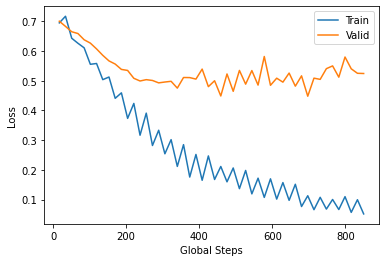

In [9]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

Model loaded from <== solo_classifier_weights/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.8462    0.7788    0.8111       113
           0     0.7951    0.8584    0.8255       113

    accuracy                         0.8186       226
   macro avg     0.8206    0.8186    0.8183       226
weighted avg     0.8206    0.8186    0.8183       226



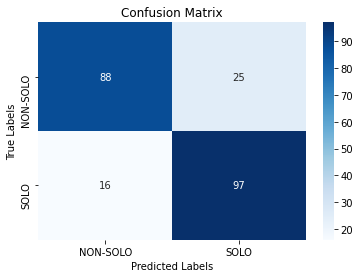

In [11]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (notes, notes_len)), _ in test_loader:           
            labels = labels.to(device)
            notes = notes.to(device)
            notes_len = notes_len.cpu()
            output = model(notes.long(), notes_len.long())

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['NON-SOLO', 'SOLO'])
    ax.yaxis.set_ticklabels(['NON-SOLO', 'SOLO'])
    
    
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)